# Data Science Practical

In [1704]:
#Library Importation 
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor,HuberRegressor

# Feature extraction and Feature engineering
### Loading Data

In [1705]:
data=pd.read_csv('./dataset/train_revised.csv', low_memory=False)

### Data description

In [1706]:
data.describe(include='all')

ride_id seat_number payment_method payment_receipt travel_date  \
count   51645.000000       51645          51645           51645       51645   
unique           NaN          61              2           51645         149   
top              NaN           1          Mpesa      1VSXHPSMF7    10-12-17   
freq             NaN        2065          51532               1         856   
mean    10188.645793         NaN            NaN             NaN         NaN   
std      2211.295708         NaN            NaN             NaN         NaN   
min      1442.000000         NaN            NaN             NaN         NaN   
25%      8287.000000         NaN            NaN             NaN         NaN   
50%     10353.000000         NaN            NaN             NaN         NaN   
75%     12029.000000         NaN            NaN             NaN         NaN   
max     20117.000000         NaN            NaN             NaN         NaN   

       travel_time travel_from travel_to car_type  max_capacity  
count        51645       51645     51645    51645  51645.000000  
unique          78          17         1        2           NaN  
top           7:09       Kisii   Nairobi      Bus           NaN  
freq          3926       22607     51645    31985           NaN  
mean           NaN         NaN       NaN      NaN     34.534321  
std            NaN         NaN       NaN      NaN     18.451193  
min            NaN         NaN       NaN      NaN     11.000000  
25%            NaN         NaN       NaN      NaN     11.000000  
50%            NaN         NaN       NaN      NaN     49.000000  
75%            NaN         NaN       NaN      NaN     49.000000  
max            NaN         NaN       NaN      NaN     49.000000

### Types of variables

In [1707]:
data.dtypes

ride_id             int64
seat_number        object
payment_method     object
payment_receipt    object
travel_date        object
travel_time        object
travel_from        object
travel_to          object
car_type           object
max_capacity        int64
dtype: object

### Checking for missing data

In [1708]:
data.isnull().sum()

ride_id            0
seat_number        0
payment_method     0
payment_receipt    0
travel_date        0
travel_time        0
travel_from        0
travel_to          0
car_type           0
max_capacity       0
dtype: int64

There is no missing data in this dataset

### Target variable construction and dropping columns

In [1709]:
#Dictionnary of ride_id [ride_id,value]
ride_group_dict=data.ride_id.value_counts()

The follwing variables are not relevant for this analysis :

<ul>
    <li>ride_id: unique ID of a vehicle on a specific route on a specific day and time. We want a general prediction but not only for a specific vehicle.<br/>
        Especially for this variable, we will remove it later on because the construction of the target variable depends on it.<br/><br/>
    </li>
    <li>seat_number :seat assigned to ticket<br/><br/></li>
    <li>payment_method :Wheter the client pay by Mpesa or Cash does not influence the number of sold ticket<br/><br/></li>
    <li>payment_receipt : this is unique for each ticket, we can never encounter two with the same. Therefore it is not relevant to predict the number of ticket<br/><br/></li>
    <li>travel_to : destination of ride. All rides are to Nairobi. it never change, so it is useless for our prediction<br/><br/></li>
</ul>
We are going to drop them.

In [1710]:
data_prepo=data.drop(['seat_number', 'payment_method', 'payment_receipt', 'travel_to'], axis=1)

Since those variables are dropped, we have now some duplicated rows and a mess for index of rows.
Let's reorganise the dataset

In [1711]:
data_prepo.drop_duplicates(inplace=True)
data_prepo.reset_index(inplace=True,drop=True)

#### Creation of target variable

In [1712]:
#Fill the column with 0
data_prepo["number_of_tickets"]= np.zeros(len(data_prepo))

In [1713]:
# Using the dictionnary of ride_id to fill the target variable
for i in range(len(data_prepo)):
    ride_id = data_prepo.loc[i]["ride_id"]
    data_prepo.at[i,"number_of_tickets"] = ride_group_dict[ride_id]

In [1714]:
#express travel time in minutes
#df_train_set["travel_time"] = df_train_set["travel_time"].str.split(':')

### Feature extraction

#### travel_date

The categorical variable travel_date has 149 unique values and each record contains the year, the month and  the day.
This variable should be splitted because only the month and the day are relevant.

Let's see that by visualizing.

In [1716]:
def hourtrans(x):
    if x[0]=='7':
        return 1
    return 0

def transtravel_from(x):
    if x=='Kisii':
        return 1
    elif x in ['Rongo','Homa']:
        return 2
    return 0

def transmonth(x):
    if x in [11,12,1,2,3,4]:
        return 1
    return 0

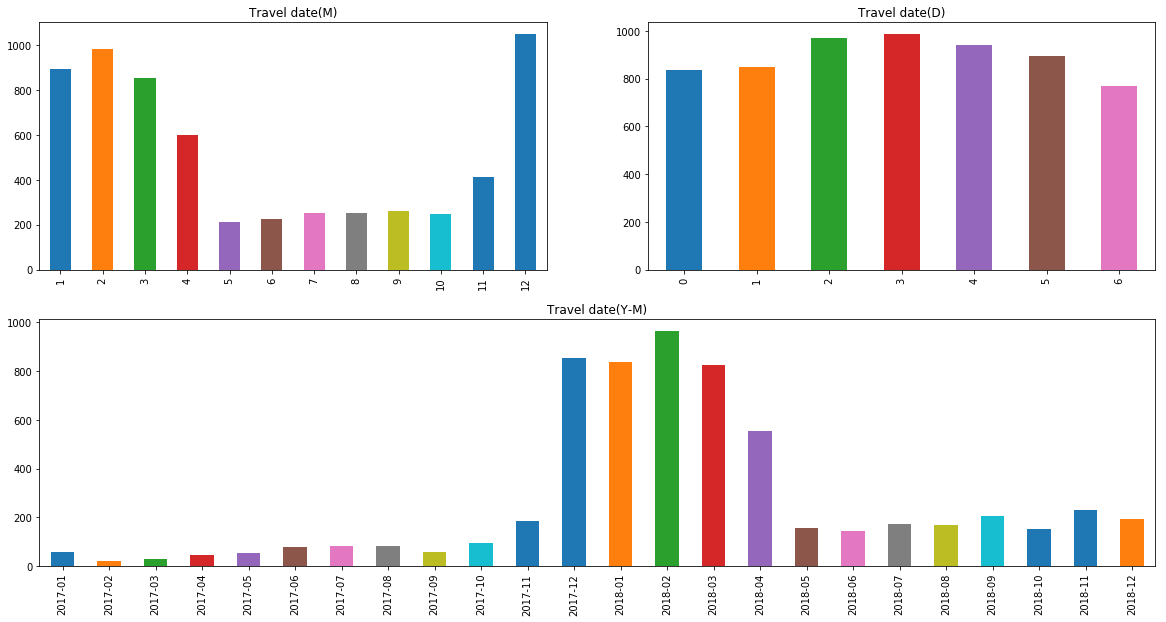

In [1717]:
data_prepo['travel_date']=pd.to_datetime(data_prepo['travel_date'],infer_datetime_format=True)
#Extraction of month year
data_prepo['m_y'] = data_prepo['travel_date'].dt.strftime('%Y-%m')

#Extraction of year
data_prepo['year'] = pd.to_numeric(data_prepo['travel_date'].dt.strftime('%Y'))

#Extraction of month
data_prepo['m'] = pd.to_numeric(data_prepo['travel_date'].dt.strftime('%m'))

#Extraction of month
data_prepo['m_g'] = data_prepo['m'].apply(transmonth)

#Extraction of day
data_prepo['day'] = data_prepo['travel_date'].dt.strftime('%w')
#data_prepo['day'] = pd.to_numeric(data_prepo['day'])
#Extraction of day
data_prepo['dm'] = data_prepo['travel_date'].dt.strftime('%d')


fig, axes = plt.subplots(figsize=(20,10),nrows=2, ncols=2)


data_prepo['m'].value_counts().sort_index().plot.bar(title='Travel date(M)',ax=axes[0,0])
data_prepo['day'].value_counts().sort_index().plot.bar(title='Travel date(D)',ax=axes[0,1])
ax_=plt.subplot(212)
data_prepo['m_y'].value_counts().sort_index().plot.bar(title='Travel date(Y-M)',ax=ax_)
plt.show()

We can see from the figure above that most of ticket are sold at the end and the begining of the year.

Therefore, the month is very important for the prediction of number of tickets

#### travel_time

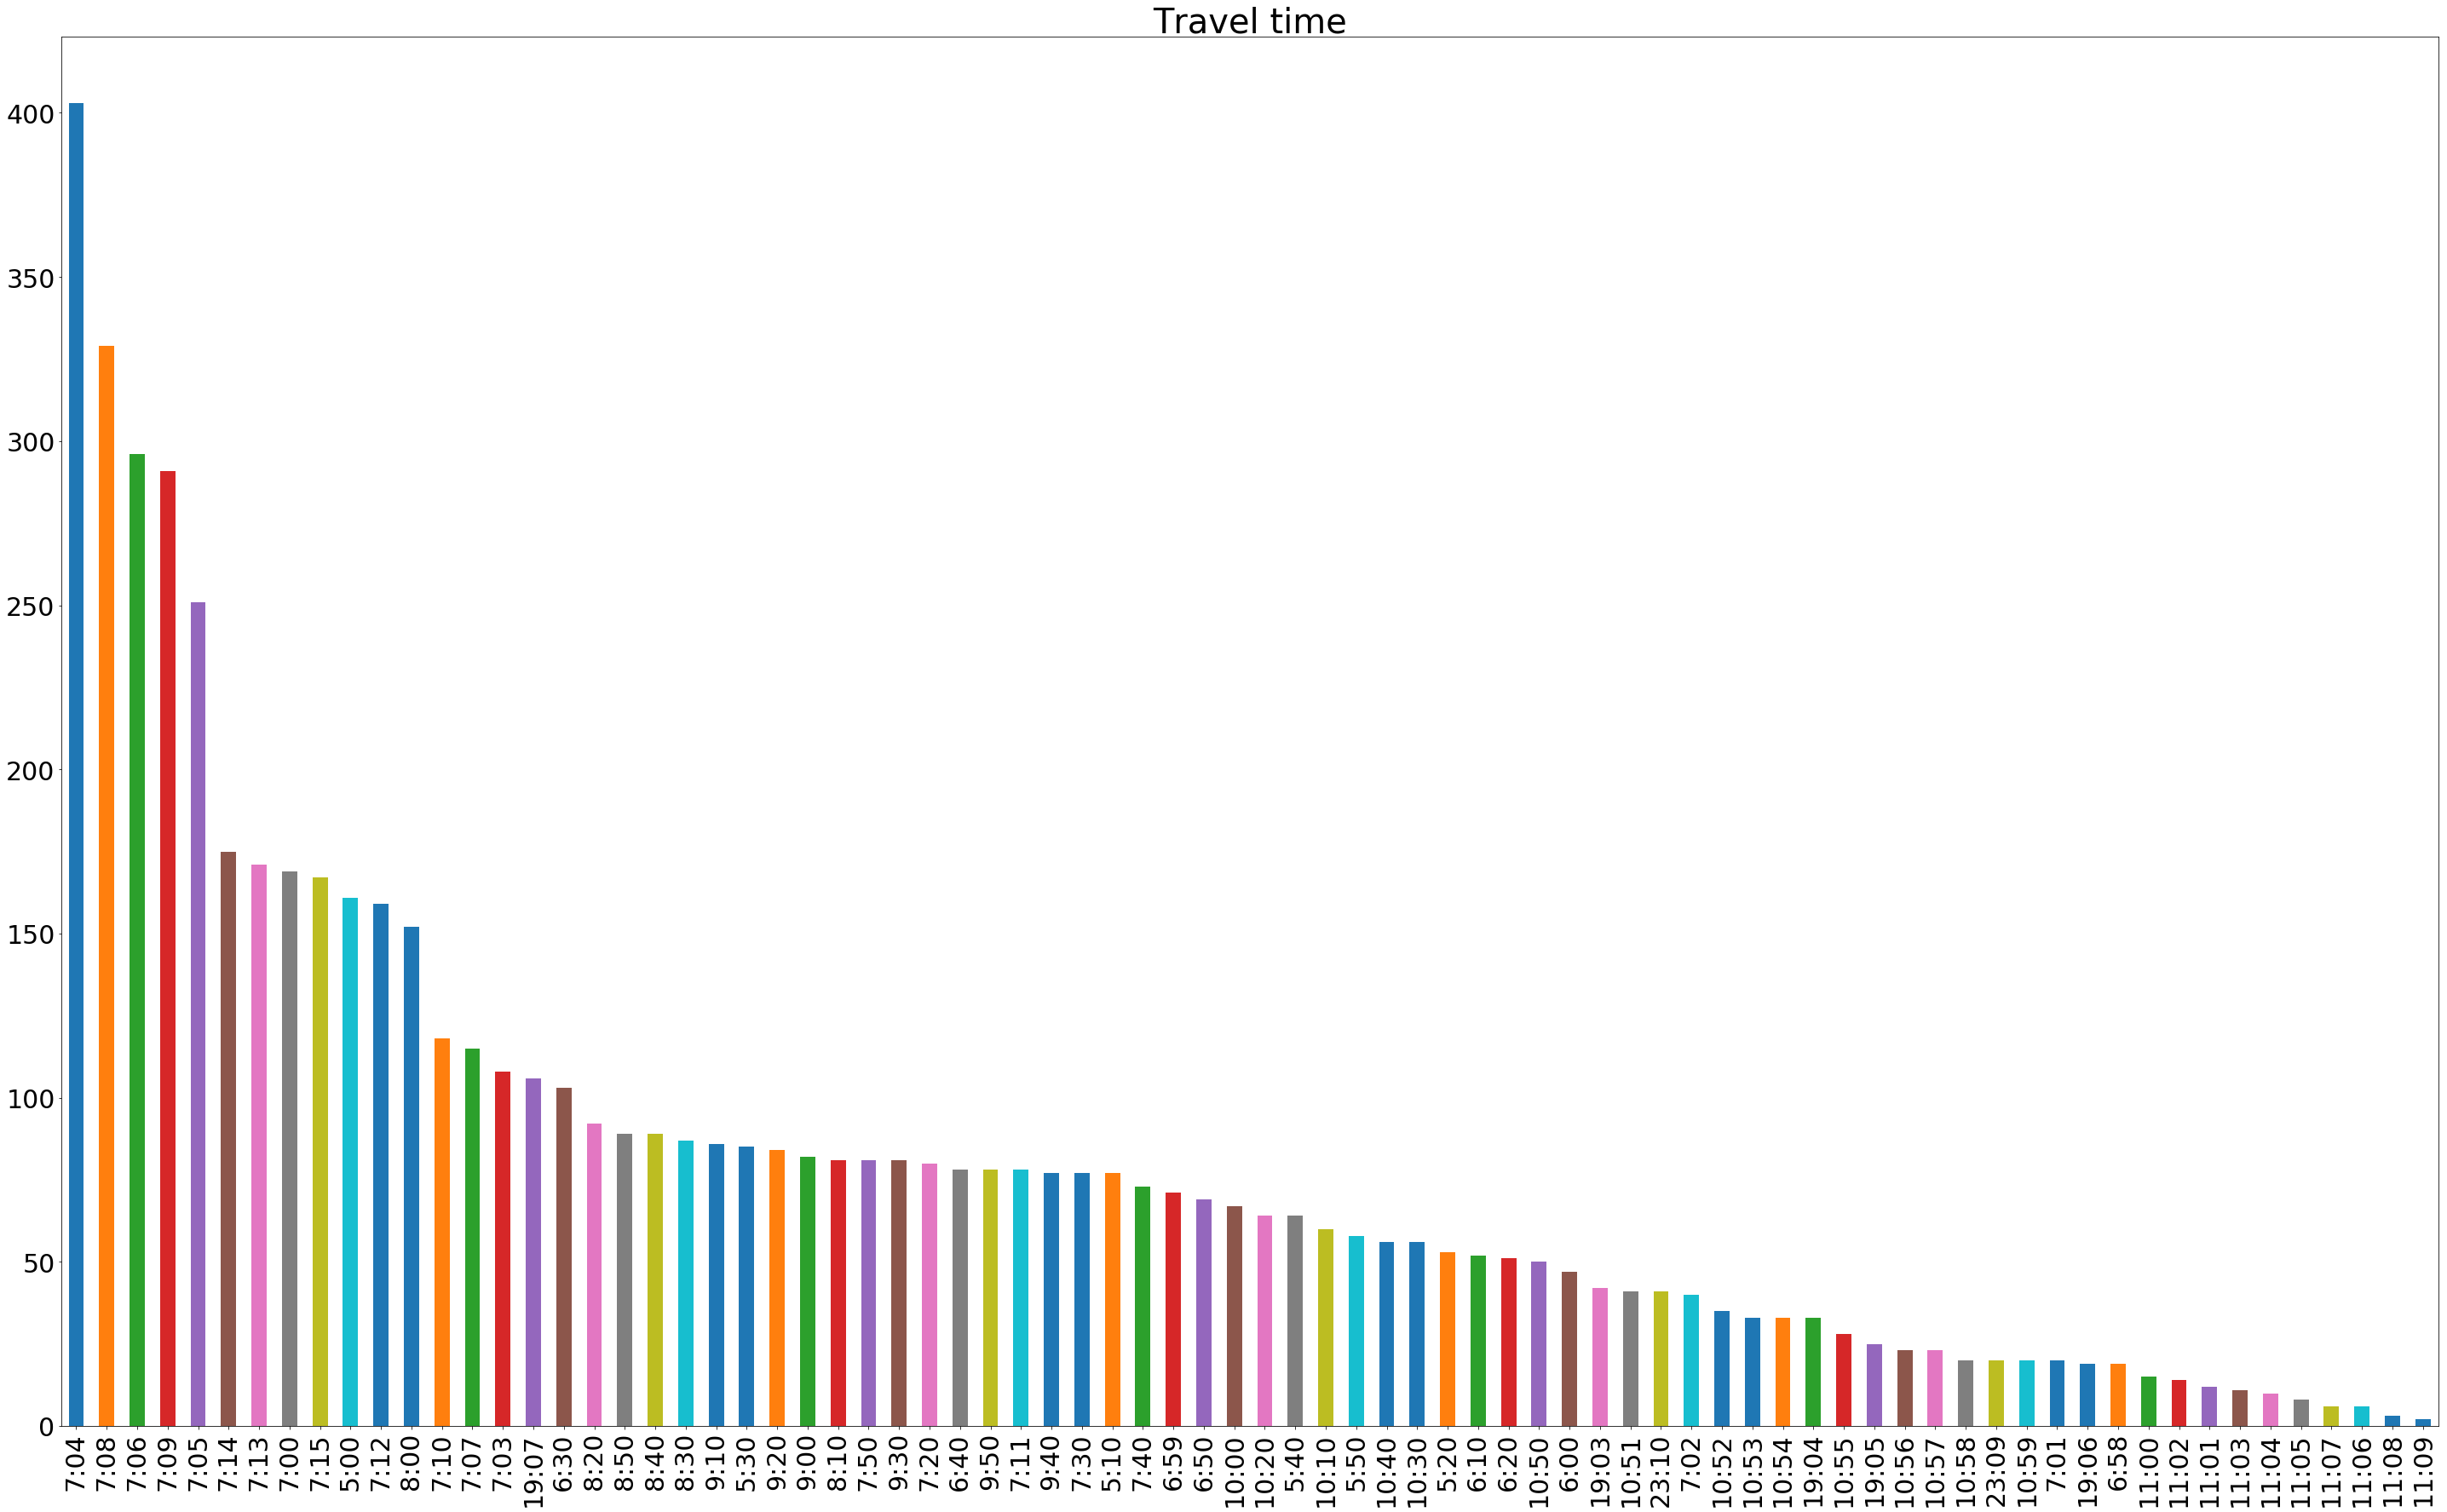

In [1718]:
axe=data_prepo['travel_time'].value_counts().plot(kind='bar', ax=None, figsize=(50,30), title='Travel time',fontsize=30)
axe.title.set_size(40)
plt.show()

As we can see it, the hour is very important variable. At 7 by example we have several ticket  for different minutes and the number of ticket is decreasing significantly after 7.

Let's extract the hour alone and time in minutes and we will see which one is producing the best performance

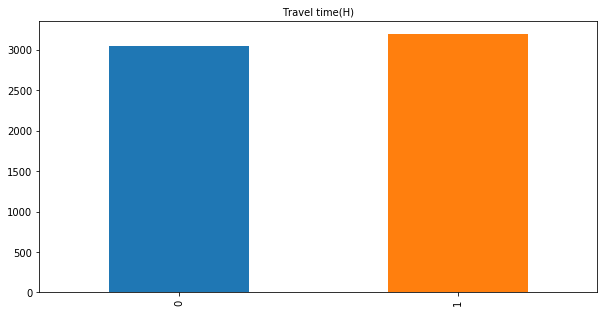

In [1719]:

data_prepo['minutes']=data_prepo["travel_time"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
data_prepo['hour']=data_prepo["travel_time"].str.split(':').apply(hourtrans)

axe=data_prepo['hour'].value_counts().sort_index().plot(kind='bar', ax=None, figsize=(10,5), title='Travel time(H)',)
axe.title.set_size(10)
plt.show()

### Codification of Categorical variables

We have two categorical variables which are : travel_from and car_type.

We should codify them so that we can use them for regression model

#### travel_from

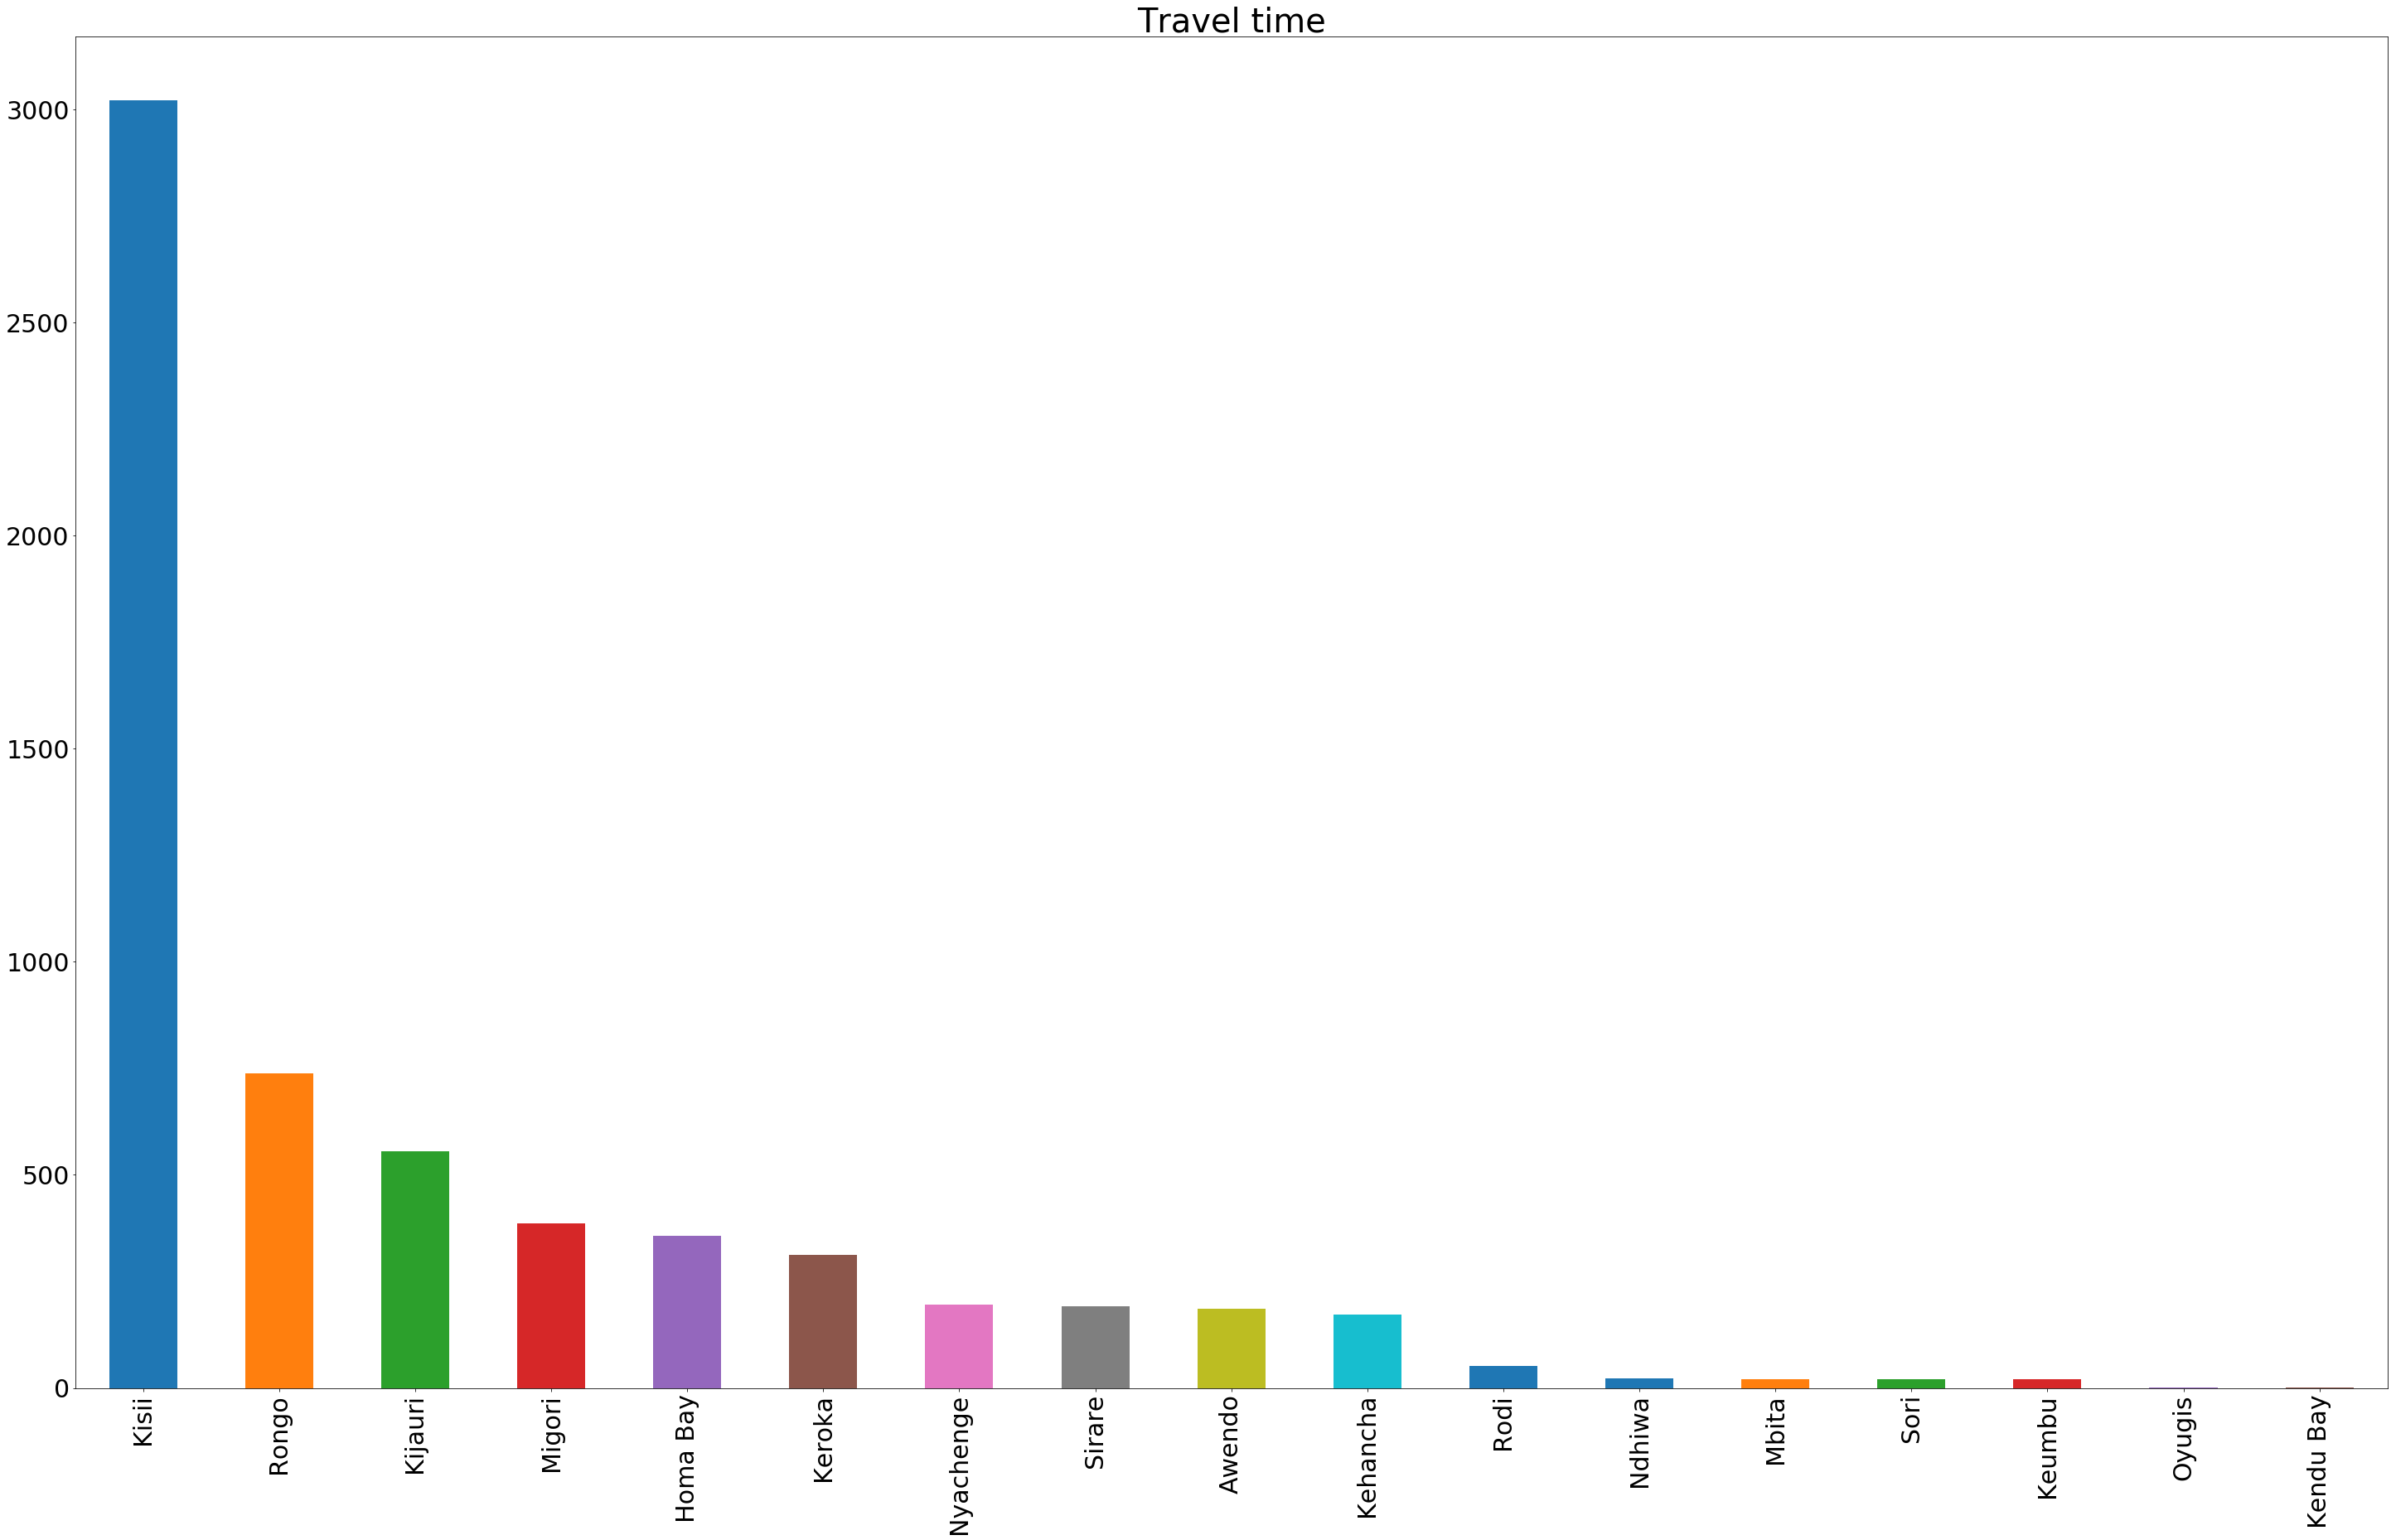

In [1720]:
axe=data_prepo['travel_from'].value_counts().plot(kind='bar', ax=None, figsize=(50,30), title='Travel time',fontsize=30)
axe.title.set_size(40)
plt.show()

In [1721]:

data_prepo['travel_from_g']=pd.to_numeric(data_prepo['travel_from'].apply(transtravel_from))

data_prepo["travel_from_coded"] = pd.Categorical(data_prepo["travel_from"])
travel_from_categories = data_prepo.travel_from_coded.cat.categories
data_prepo["travel_from_coded"] = data_prepo.travel_from_coded.cat.codes

#### car_type

In [1722]:
data_prepo["car_type_coded"] = pd.Categorical(data_prepo["car_type"])
car_type_categories = data_prepo.car_type_coded.cat.categories
data_prepo["car_type_coded"] = data_prepo.car_type_coded.cat.codes

In [1723]:
#dropping ride_id
data_prepo=data_prepo.drop(['ride_id'], axis=1)
data_prepo.drop(
    data_prepo[data_prepo["travel_from"]=="Keumbu"].index,inplace=True)
data_prepo.drop(
    data_prepo[data_prepo["travel_from"]=="Kendu Bay"].index,inplace=True)
#Keumbu,Kendu Bay 
data_prepo.to_csv('train_set_clean.csv', index=False)


In [1724]:
data_prepo.head(10)

travel_date travel_time travel_from car_type  max_capacity  \
0  2017-10-17        7:15      Migori      Bus            49   
1  2017-11-19        7:12      Migori      Bus            49   
2  2017-11-26        7:05      Keroka      Bus            49   
3  2017-11-27        7:10    Homa Bay      Bus            49   
4  2017-11-27        7:12      Migori      Bus            49   
5  2017-11-27        7:09    Homa Bay      Bus            49   
6  2018-04-20        5:10       Kisii  shuttle            11   
7  2018-04-20        9:50       Kisii  shuttle            11   
8  2018-04-20        7:06       Kisii      Bus            49   
9  2018-04-20        6:00       Kisii  shuttle            11   

   number_of_tickets      m_y  year   m  m_g day  dm  minutes  hour  \
0                1.0  2017-10  2017  10    0   2  17      435     1   
1                1.0  2017-11  2017  11    1   0  19      432     1   
2                1.0  2017-11  2017  11    1   0  26      425     1   
3                5.0  2017-11  2017  11    1   1  27      430     1   
4               31.0  2017-11  2017  11    1   1  27      432     1   
5               26.0  2017-11  2017  11    1   1  27      429     1   
6                1.0  2018-04  2018   4    1   5  20      310     0   
7                1.0  2018-04  2018   4    1   5  20      590     0   
8                2.0  2018-04  2018   4    1   5  20      426     1   
9                1.0  2018-04  2018   4    1   5  20      360     0   

   travel_from_g  travel_from_coded  car_type_coded  
0              0                  9               0  
1              0                  9               0  
2              0                  4               0  
3              0                  1               0  
4              0                  9               0  
5              0                  1               0  
6              1                  7               1  
7              1                  7               1  
8              1                  7               0  
9              1                  7               1

# Prediction model

In [1494]:
scaler = StandardScaler() 
def pred_split_(X,y,model):
    seed = 7
    np.random.seed(seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=seed)
    #scaler.fit(X_train) 
    #X_train=scaler.transform(X_train) 
    #X_test=scaler.transform(X_test)
    model_1 = model
    model_1.fit(X_train,y_train)
    nt_1_test_set = model_1.predict(X_test)
    print (mean_absolute_error(nt_1_test_set,y_test))
    return model_1

def pred_no_split_(X,y,model):
    model = model
    #scaler.fit(X) 
    #X=scaler.transform(X) 
    model.fit(X,y)
    pred_train_set = model.predict(X)
    print (mean_absolute_error(pred_train_set,y))
    return model

def pred_and_save(X,keys,file_name,model):
    data_test_set_predictions=model.predict(X)
    data_dict = {'ride_id': keys, 'number_of_ticket': data_test_set_predictions}
    df_predictions = pd.DataFrame(data=data_dict)
    df_predictions = df_predictions[['ride_id','number_of_ticket']]
    df_predictions.to_csv('preds_test_set{}.csv'.format(file_name), index=False)
    return df_predictions

def pred_and_save_int(X,keys,file_name,model):
    data_test_set_predictions=model.predict(X)
    data_dict = {'ride_id': keys, 'number_of_ticket': np.rint(data_test_set_predictions)}
    df_predictions = pd.DataFrame(data=data_dict)
    df_predictions = df_predictions[['ride_id','number_of_ticket']]
    df_predictions.to_csv('preds_test_set{}.csv'.format(file_name), index=False)
    return df_predictions

### Loading test data

In [1725]:
data_test_set = pd.read_csv('./dataset/test_questions.csv', low_memory=False)

In [1726]:
axe=data_test_set['travel_from'].value_counts().plot(kind='bar', ax=None, figsize=(50,30), title='Travel time',fontsize=30)
axe.title.set_size(40)
plt.show()

In [1727]:
data_test_set['travel_from'].value_counts()

Kisii        545
Rongo        115
Kijauri       79
Homa Bay      53
Awendo        44
Rodi          43
Migori        41
Nyachenge     34
Kehancha      32
Ndhiwa        29
Sirare        28
Mbita         25
Keroka        21
Oyugis        12
Sori          10
Name: travel_from, dtype: int64

In [1728]:

data_test_set['travel_from_g']=pd.to_numeric(data_test_set['travel_from'].apply(transtravel_from))

data_test_set['travel_date']=pd.to_datetime(data_test_set['travel_date'],infer_datetime_format=True)

#Extraction of month year
data_test_set['m_y'] = data_test_set['travel_date'].dt.strftime('%Y-%m')


#Extraction of year
data_test_set['year'] = pd.to_numeric(data_test_set['travel_date'].dt.strftime('%Y'))


#Extraction of month
data_test_set['m'] = pd.to_numeric(data_test_set['travel_date'].dt.strftime('%m'))

#Extraction of month group
data_test_set['m_g'] = data_test_set['m'].apply(transmonth)

#Extraction of day
data_test_set['day'] = pd.to_numeric(data_test_set['travel_date'].dt.strftime('%w'))
data_test_set['dm'] = pd.to_numeric(data_test_set['travel_date'].dt.strftime('%d'))

# Time extration
data_test_set['minutes']=data_test_set["travel_time"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
data_test_set['hour']=data_test_set["travel_time"].str.split(':').apply(hourtrans)

#Categorical variable coding
data_test_set["car_type_coded"] = pd.Categorical(data_test_set["car_type"], categories=car_type_categories)
data_test_set["car_type_coded"] = data_test_set.car_type_coded.cat.codes

data_test_set["travel_from_coded"] = pd.Categorical(data_test_set["travel_from"], categories=travel_from_categories)
data_test_set["travel_from_coded"] = data_test_set.travel_from_coded.cat.codes
# Dropping unnecessary variables
keys=data_test_set['ride_id']
data_test_set.drop(['ride_id','travel_date','travel_time','travel_from','travel_to','car_type'],axis=1,inplace=True)
#data_test_set.to_csv('test_set{}.csv'.format('5'), index=False)
data_test_set.boxplot(figsize=(15,7))
plt.title('')

Text(0.5, 1.0, '')

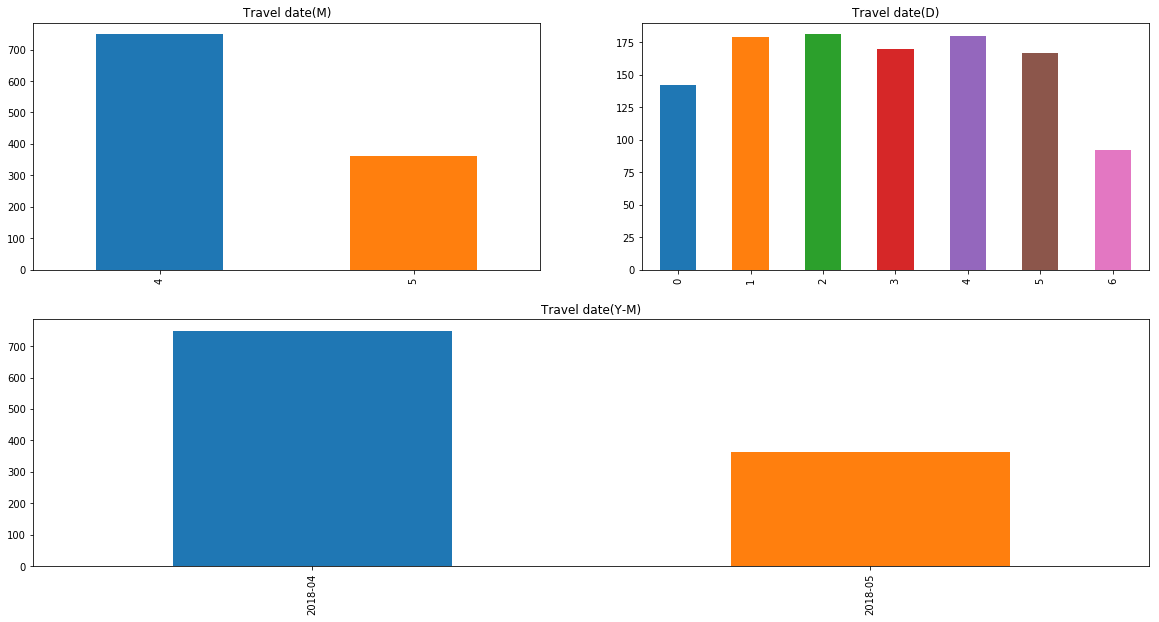

In [1729]:
fig, axes = plt.subplots(figsize=(20,10),nrows=2, ncols=2)


data_test_set['m'].value_counts().sort_index().plot.bar(title='Travel date(M)',ax=axes[0,0])
data_test_set['day'].value_counts().sort_index().plot.bar(title='Travel date(D)',ax=axes[0,1])
ax_=plt.subplot(212)
data_test_set['m_y'].value_counts().sort_index().plot.bar(title='Travel date(Y-M)',ax=ax_)
plt.show()

### Building different model

#### ExtraTreeRegressor

In [1105]:
from sklearn.tree import ExtraTreeRegressor
def getmodel():
    return ExtraTreeRegressor(
    criterion='mae',
    splitter='random', 
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0,
    max_features='auto', 
    random_state=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    max_leaf_nodes=None)

X= data_prepo.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
y = data_prepo.number_of_tickets

model_1=pred_no_split_(X,y,getmodel())
model_1_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
df1=pred_and_save(X_test,keys,'1',model_1_)
df1_=pred_and_save(X_test,keys,'1_',model_1)
#print(df1)
#print(df1_)

3.0237636480411045
3.8274478330658104


#### BaggingRegressor

In [1106]:
from sklearn.ensemble import BaggingRegressor
def getmodel():
    return BaggingRegressor(
    base_estimator=None, 
    n_estimators=10, max_samples=1.0, 
    max_features=1.0,
    bootstrap=True, 
    bootstrap_features=False, 
    oob_score=False, 
    warm_start=False, 
    n_jobs=-1, 
    random_state=None, 
    verbose=0)
X= data_prepo.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
y = data_prepo.number_of_tickets

model_2=pred_no_split_(X,y,getmodel())
model_2_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
df2=pred_and_save(X_test,keys,'2',model_2_)
df2_=pred_and_save(X_test,keys,'2_',model_2)



3.348124354896308
3.9106143189701483


In [1107]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import  SVR

def getmodel():
    return BaggingRegressor(
    base_estimator=RandomForestRegressor(
        n_estimators=100, criterion="mae",
        n_jobs=-1),#SVR(kernel='rbf', C=1e3, gamma=.1,degree=2), 
    n_estimators=10, max_samples=1.0, 
    max_features=1.0,
    bootstrap=True, 
    bootstrap_features=False, 
    oob_score=False, 
    warm_start=False, 
    n_jobs=-1, 
    random_state=None, 
    verbose=0)
X= data_prepo.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
y = data_prepo.number_of_tickets

model_2=pred_no_split_(X,y,getmodel())
model_2_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
df2_1=pred_and_save(X_test,keys,'2',model_2_)
df2__1=pred_and_save(X_test,keys,'2_',model_2)

3.3031058124598585
3.7020168539325846


In [1124]:
from sklearn.ensemble import ExtraTreesRegressor

def getmodel():
    return ExtraTreesRegressor(
    n_estimators=100, 
    criterion='mae', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0,
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    bootstrap=False, 
    oob_score=False, 
    n_jobs=None, 
    random_state=None, 
    verbose=0, 
    warm_start=False)

X= data_prepo.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
y = data_prepo.number_of_tickets

model_3=pred_no_split_(X,y,getmodel())
model_3_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
df3=pred_and_save(X_test,keys,'3',model_3_)
df3_=pred_and_save(X_test,keys,'3_',model_3)

3.0312042389210014
3.798334670947031


In [1129]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

def getmodel():
    kernel = None
    return GaussianProcessRegressor(
    kernel=kernel, 
    alpha=1e-10, 
    optimizer='fmin_l_bfgs_b', 
    n_restarts_optimizer=0,
    normalize_y=False, 
    copy_X_train=True, 
    random_state=None)

X= data_prepo.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
y = data_prepo.number_of_tickets

model_4=pred_no_split_(X,y,getmodel())
model_4_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
df4=pred_and_save(X_test,keys,'4',model_4_)
df4_=pred_and_save(X_test,keys,'4_',model_4)

3.2671896005164824
4.002751034869762


In [1141]:
from sklearn.neighbors import RadiusNeighborsRegressor
def getmodel():
    kernel = None
    return RadiusNeighborsRegressor(
        radius=10, 
        weights='uniform', 
        algorithm='auto', 
        leaf_size=30,
        p=2, 
        metric='minkowski', 
        metric_params=None, 
        n_jobs=None)

X= data_prepo.filter(["day","minutes","travel_from_coded","travel_from_g","car_type_coded",'max_capacity'], axis=1)
y = data_prepo.number_of_tickets

model_5=pred_no_split_(X,y,getmodel())
#model_5_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
#df5=pred_and_save(X_test,keys,'5',model_5_)
df5_=pred_and_save(X_test,keys,'5_',model_5)

5.666812632458482


In [1150]:
from sklearn.neural_network import MLPRegressor
def getmodel():
    kernel = None
    return MLPRegressor(
        hidden_layer_sizes=(100, ),
        activation='logistic',
        solver='lbfgs', 
        alpha=0.0001, 
        batch_size='auto', 
        learning_rate='constant', 
        learning_rate_init=0.001, 
        power_t=0.5, 
        max_iter=1000, 
        shuffle=True, 
        random_state=None, 
        tol=0.0001,
        verbose=False,
        warm_start=False,
        momentum=0.9, 
        nesterovs_momentum=True,
        early_stopping=False, 
        validation_fraction=0.1, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=1e-08, 
        n_iter_no_change=10)

X= data_prepo.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
y = data_prepo.number_of_tickets

model_6=pred_no_split_(X,y,getmodel())
model_6_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
df6=pred_and_save(X_test,keys,'6',model_6_)
df6_=pred_and_save(X_test,keys,'6_',model_6)

5.082694046191111
4.870450096876928


In [1171]:
from sklearn.neighbors import KNeighborsRegressor
def getmodel():
    kernel = None
    return KNeighborsRegressor(
        n_neighbors=5, 
        weights='uniform', #uniform,distance
        algorithm='auto', 
        leaf_size=100, 
        p=5, 
        metric='minkowski', 
        metric_params=None, 
        n_jobs=None)


X= data_prepo.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
y = data_prepo.number_of_tickets

model_7=pred_no_split_(X,y,getmodel())
model_7_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
df7=pred_and_save(X_test,keys,'7',model_7_)
df7_=pred_and_save(X_test,keys,'7_',model_7)

3.770905587668593
4.18828250401284


In [1613]:


from sklearn.ensemble import GradientBoostingRegressor
def getmodel():
    kernel = None
    return GradientBoostingRegressor(
        loss='lad', 
        learning_rate=0.1, 
        n_estimators=200, 
        subsample=1.0, 
        criterion='mae', 
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0,
        max_depth=100, 
        min_impurity_decrease=0.0, 
        min_impurity_split=None, 
        init=None, 
        random_state=None, 
        max_features=None, 
        alpha=0.9, verbose=0, 
        max_leaf_nodes=None, 
        warm_start=True, 
        presort='auto', 
        validation_fraction=0.2, 
        n_iter_no_change=None, 
        tol=0.000001)


index=['year',
       #'m',
       'm_g',
       'day'
       'dm',
       "hour",
       'minutes',
       "travel_from_coded",
       #'travel_from_g',
       "car_type_coded",
       #'max_capacity'
      ]#,"travel_from_coded"

X= data_prepo.filter(index, axis=1)
y = data_prepo.number_of_tickets

model_8=pred_no_split_(X,y,getmodel())
model_8_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
df8=pred_and_save(X_test,keys,'8',model_8_)
df8_=pred_and_save(X_test,keys,'8_',model_8)

3.157354057457037
3.517539557762949


ValueError: Number of features of the model must match the input. Model n_features is 6 and input n_features is 5 

In [1615]:
X_test=data_test_set.filter(index, axis=1)
df8=pred_and_save(X_test,keys,'8',model_8_)
df8_=pred_and_save(X_test,keys,'8_',model_8)

In [1749]:
from sklearn.ensemble import RandomForestRegressor
def getmodel():
    kernel = None
    return RandomForestRegressor(
        n_estimators=20, 
        criterion='mae', 
        max_depth=None,
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0,
        max_features='auto', 
        max_leaf_nodes=None, 
        min_impurity_decrease=0.0,
        min_impurity_split=None, 
        bootstrap=True, 
        oob_score=False, 
        n_jobs=None, 
        random_state=None, 
        verbose=0,
        warm_start=False)

index=[#'year',
       #'m',
       #'m_g',
       #'day'
       #'dm',
      "hour",
       'minutes',
       "travel_from_coded",
       #'travel_from_g',
       "car_type_coded",
       'max_capacity'
      ]#,"travel_from_coded"


Xt=data_prepo[(data_prepo.m==4) | (data_prepo.m==5)]
X= Xt.filter(index, axis=1)

y = Xt.number_of_tickets

model_9=pred_no_split_(X,y,getmodel())
model_9_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(index, axis=1)
df9=pred_and_save(X_test,keys,'9',model_9_)
df9_=pred_and_save(X_test,keys,'9_',model_9)


2.8529702970297026
3.5614197530864202


In [1741]:
df9_=pred_and_save_int(X_test,keys,'9_i',model_9)
df9=pred_and_save_int(X_test,keys,'9i',model_9_)

In [1750]:
data2=pd.read_csv('./best/preds_test_set9_i.csv', low_memory=False)
pd.concat([data2,
           df9.drop(['ride_id'],axis=1),
            df9_.drop(['ride_id'],axis=1),
           df8.drop(['ride_id'],axis=1),
           df8_.drop(['ride_id'],axis=1)
          ],axis=1,sort=False)

ride_id  number_of_ticket  number_of_ticket  number_of_ticket  \
0         247               5.0             6.300             4.975   
1         256               6.0             4.650             3.150   
2         275               1.0             2.300             1.875   
3         285              10.0             7.375             6.575   
4         286              10.0             8.500             8.125   
5         287               4.0             6.725             8.775   
6         288               9.0             7.800             8.050   
7         292               7.0            14.925             9.075   
8         298               9.0             5.525             5.200   
9         302               9.0             7.000             7.175   
10        310               2.0            12.675             9.150   
11        311               9.0             6.725             6.475   
12        329               5.0             8.925            10.300   
13        341               9.0             6.050             6.350   
14        344              10.0             7.050             6.375   
15        358              10.0             8.175             7.975   
16        364               1.0             4.900             4.225   
17        373               9.0             6.575             7.900   
18        374               9.0             7.575             8.125   
19        377               8.0             8.000             8.050   
20        399               8.0             1.750             2.000   
21        401               5.0             1.250             1.150   
22        410               8.0             1.600             1.400   
23        418               5.0             6.300             4.975   
24        427               6.0             1.450             1.500   
25        432               2.0             1.450             1.000   
26        434               1.0             1.000             1.000   
27        436               1.0             1.025             1.000   
28        438              11.0             5.125            20.150   
29        464               2.0             6.000             5.500   
...       ...               ...               ...               ...   
1081    15295               2.0             5.100             3.400   
1082    15296               3.0             3.475             3.375   
1083    15297              20.0            15.850            19.025   
1084    15298               2.0             1.425             1.750   
1085    15299              19.0            24.575            21.150   
1086    15300              30.0            28.250            27.650   
1087    15301               8.0             7.450             8.200   
1088    15302              23.0            13.950            29.175   
1089    15303               7.0             4.475             5.775   
1090    15304               9.0            12.600             9.425   
1091    15305              13.0            14.325            14.975   
1092    15306              12.0             6.800             8.600   
1093    15307              11.0            11.450            11.725   
1094    15316              30.0            20.850            28.750   
1095    15317              20.0            15.850            19.025   
1096    15318               2.0             5.100             3.400   
1097    15319               8.0             7.450             8.200   
1098    15320               7.0             4.475             5.775   
1099    15321               7.0             7.525             8.575   
1100    15322              19.0            24.575            21.150   
1101    15323              30.0            28.250            27.650   
1102    15324               3.0             3.475             3.375   
1103    15325              10.0             9.150            11.450   
1104    15326              10.0             7.850             9.850   
1105    15335               7.

In [1363]:
df9=pred_and_save_int(X_test,keys,'9',model_9_)
#df9_=pred_and_save_int(X_test,keys,'9_',model_9)

In [1308]:

from sklearn.ensemble import  AdaBoostRegressor,RandomForestRegressor
def getmodel():
    kernel = RandomForestRegressor(
        n_estimators=10, 
        criterion='mae', 
        max_depth=None,
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0,
        max_features='auto', 
        max_leaf_nodes=None, 
        min_impurity_decrease=0.0,
        min_impurity_split=None, 
        bootstrap=True, 
        oob_score=False, 
        n_jobs=None, 
        random_state=None, 
        verbose=0, 
        warm_start=False)
    return AdaBoostRegressor(
        base_estimator=kernel,
        n_estimators=100, 
        learning_rate=1.0, 
        loss='linear', 
        random_state=None)


X= data_prepo.filter(['day',"minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
y = data_prepo.number_of_tickets

model_10=pred_no_split_(X,y,getmodel())
model_10_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
df10=pred_and_save(X_test,keys,'10',model_10_)
df10_=pred_and_save(X_test,keys,'10_',model_10)

4.0300497752087345
4.402407704654896


In [1381]:


from sklearn.linear_model import  LogisticRegression
def getmodel():
    return LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=-1)

X_d= data_prepo.filter(['day',"minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
X= pd.concat([
           pred_and_save(X_d,data_prepo.filter(['ride_id']),'__',model_9_).drop(['ride_id'],axis=1),
           pred_and_save(X_d,data_prepo.filter(['ride_id']),'__',model_8).drop(['ride_id'],axis=1),
           pred_and_save(X_d,data_prepo.filter(['ride_id']),'__',model_8_).drop(['ride_id'],axis=1)
          ],axis=1,sort=False)

y = data_prepo.number_of_tickets

model_12=pred_no_split_(X,y,getmodel())
model_12_=pred_split_(X,y,getmodel())

X_test=data_test_set.filter(["day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
df12=pred_and_save(X_test,keys,'12',model_12_)
df12_=pred_and_save(X_test,keys,'12_',model_12)

ValueError: Empty data passed with indices specified.

In [1376]:
df12

ride_id  number_of_ticket
0         247          9.740521
1         256          8.306132
2         275          4.357518
3         285          6.968881
4         286          7.073336
5         287          9.614989
6         288          7.177790
7         292         17.146160
8         298          6.864427
9         302          6.655518
10        310         10.220825
11        311          6.759972
12        329          9.604544
13        341          6.446609
14        344          6.551063
15        358          6.342154
16        364          5.767654
17        373          6.133245
18        374          6.028791
19        377          9.667216
20        399          5.402064
21        401          5.297609
22        410          5.193155
23        418          9.656771
24        427          5.088700
25        432          4.775336
26        434          4.879791
27        436          4.670882
28        438         17.156605
29        464          4.587365
...       ...               ...
1081    15295          8.425253
1082    15296          8.677814
1083    15297         11.004967
1084    15298          8.045475
1085    15299          9.736546
1086    15300          9.235165
1087    15301         10.815078
1088    15302         19.463133
1089    15303          8.003693
1090    15304         11.330646
1091    15305         10.867305
1092    15306          9.372826
1093    15307         19.010237
1094    15316         11.182819
1095    15317         11.130592
1096    15318          8.550878
1097    15319         10.940703
1098    15320          8.129318
1099    15321         18.693411
1100    15322          9.862172
1101    15323          9.360790
1102    15324          8.803439
1103    15325          9.056001
1104    15326          8.360989
1105    15335         18.672474
1106    15336          8.529940
1107    15337         10.919765
1108    15338          8.097935
1109    15339          9.035063
1110    15344          9.799359

[1111 rows x 2 columns]

ride_id  number_of_ticket  ride_id  number_of_ticket
0         247            4.5750      247               4.8
1         256            5.0325      256               6.5
2         275            1.0400      275               1.0
3         285            9.5350      285              10.3
4         286           10.0575      286               9.8
5         287            7.4750      287               9.4
6         288           10.0500      288               9.7
7         292            9.8400      292               9.3
8         298            8.7650      298               8.6
9         302            9.3950      302               9.3
10        310            3.2100      310               1.8
11        311            8.6700      311               8.3
12        329            3.3550      329               2.6
13        341            9.2900      341               8.3
14        344            9.8750      344               9.0
15        358           10.0075      358               9.7
16        364            5.1675      364               4.1
17        373            9.6300      373              10.0
18        374            8.0825      374               7.2
19        377            9.3500      377               8.8
20        399            6.7225      399               8.6
21        401            7.5025      401               7.6
22        410            8.9175      410               9.9
23        418            8.1400      418               8.8
24        427            5.3550      427               7.9
25        432            3.5750      432               4.1
26        434            1.3450      434               1.2
27        436            1.0275      436               1.0
28        438           13.0500      438              13.6
29        464            3.8600      464               1.0
...       ...               ...      ...               ...
1081    15295            4.1400    15295               2.6
1082    15296            2.8525    15296               2.8
1083    15297           21.4675    15297              23.6
1084    15298            2.0350    15298               2.0
1085    15299           19.3275    15299              18.2
1086    15300           25.9600    15300              25.5
1087    15301           10.0775    15301              10.9
1088    15302           16.4625    15302              23.1
1089    15303            4.4425    15303               3.9
1090    15304            7.2150    15304               8.9
1091    15305           11.9250    15305              11.2
1092    15306           10.7650    15306              13.1
1093    15307           12.2750    15307              12.0
1094    15316           31.1175    15316              30.3
1095    15317           22.0850    15317              23.3
1096    15318            5.3400    15318               3.6
1097    15319           10.3325    15319              11.1
1098    15320            6.4000    15320               6.2
1099    15321            5.6225    15321               1.0
1100    15322           26.2900    15322              27.4
1101    15323           31.2975    15323              33.1
1102    15324            3.9125    15324               3.2
1103    15325           10.5950    15325               9.5
1104    15326            8.8375    15326               8.0
1105    15335            6.2025    15335               1.0
1106    15336            3.2950    15336               3.3
1107    15337            7.7225    15337               7.5
1108    15338            4.1125    15338               3.9
1109    15339            8.5000    15339               9.5
1110    15344           18.4925    15344              17.8

[1111 rows x 4 columns]

In [1197]:
mean_absolute_error(data2.drop('ride_id',axis=1),df8.drop('ride_id',axis=1))

1.278330456437481

In [1184]:
df8_

ride_id  number_of_ticket
0         247          6.371947
1         256          7.889578
2         275          2.509813
3         285          8.364041
4         286          8.364041
5         287          6.202954
6         288          8.364041
7         292          8.001368
8         298          8.364041
9         302          8.364041
10        310          8.239532
11        311          8.364041
12        329          6.202954
13        341          8.364041
14        344          8.364041
15        358          8.364041
16        364          8.097971
17        373          8.364041
18        374          8.364041
19        377          6.202954
20        399          5.917700
21        401          5.329423
22        410          5.329423
23        418          6.202954
24        427          5.329423
25        432          3.823739
26        434          3.823739
27        436          3.151868
28        438          8.291147
29        464          3.693266
...       ...               ...
1081    15295          2.535205
1082    15296          2.952542
1083    15297         19.189189
1084    15298          3.178437
1085    15299         16.333406
1086    15300         23.676707
1087    15301         10.070118
1088    15302         15.860708
1089    15303          6.466643
1090    15304          8.397080
1091    15305         11.852923
1092    15306         11.094245
1093    15307         11.527146
1094    15316         27.577866
1095    15317         19.729819
1096    15318          2.594923
1097    15319          9.449119
1098    15320          6.635636
1099    15321          3.554085
1100    15322         16.333406
1101    15323         23.659497
1102    15324          3.012260
1103    15325          9.375429
1104    15326          8.289091
1105    15335          3.554085
1106    15336          2.594923
1107    15337          9.074799
1108    15338          5.510482
1109    15339          9.375429
1110    15344         16.333406

[1111 rows x 2 columns]

0.9092889288928893

In [1130]:
data2=pd.read_csv('./3.91/preds_test_set3_.csv', low_memory=False)
pd.concat([
    data2,
    df1.drop('ride_id',axis=1),
    df1_.drop('ride_id',axis=1),
    df2.drop('ride_id',axis=1),
    df2_.drop('ride_id',axis=1),
    df3.drop('ride_id',axis=1),
    df3_.drop('ride_id',axis=1),
    df4.drop('ride_id',axis=1),
    df4_.drop('ride_id',axis=1)

    ],
    axis=1,sort=False)

ride_id  number_of_ticket  number_of_ticket  number_of_ticket  \
0         247            4.5750               4.5               5.0   
1         256            5.0325               3.0               3.0   
2         275            1.0400               1.0               1.0   
3         285            9.5350              10.5              10.5   
4         286           10.0575              11.0              11.0   
5         287            7.4750               9.0               9.0   
6         288           10.0500              11.0              11.0   
7         292            9.8400              10.0              10.0   
8         298            8.7650               9.0               9.5   
9         302            9.3950               9.5               9.5   
10        310            3.2100               1.0               1.0   
11        311            8.6700               8.5               9.0   
12        329            3.3550               3.0               3.0   
13        341            9.2900               9.0               9.0   
14        344            9.8750              10.0              10.0   
15        358           10.0075              10.0              10.0   
16        364            5.1675              11.0              11.0   
17        373            9.6300              10.0              10.0   
18        374            8.0825               7.0               8.0   
19        377            9.3500               9.5               3.0   
20        399            6.7225               6.0               6.0   
21        401            7.5025               9.0               8.0   
22        410            8.9175               9.0               9.0   
23        418            8.1400               8.5               6.0   
24        427            5.3550               5.0               4.5   
25        432            3.5750               3.5               1.0   
26        434            1.3450               1.0               1.0   
27        436            1.0275               1.0               1.0   
28        438           13.0500              13.0              13.0   
29        464            3.8600               1.0               6.0   
...       ...               ...               ...               ...   
1081    15295            4.1400               1.0               1.0   
1082    15296            2.8525               3.0               3.0   
1083    15297           21.4675              21.0              21.0   
1084    15298            2.0350               2.0               2.0   
1085    15299           19.3275              19.5              19.5   
1086    15300           25.9600              25.5              25.5   
1087    15301           10.0775              10.0               9.5   
1088    15302           16.4625              16.0              16.0   
1089    15303            4.4425               4.0               6.0   
1090    15304            7.2150               6.0               8.0   
1091    15305           11.9250              12.0              13.0   
1092    15306           10.7650              12.0              20.5   
1093    15307           12.2750              12.0              12.0   
1094    15316           31.1175              31.0              31.5   
1095    15317           22.0850              22.5              26.0   
1096    15318            5.3400               4.0               4.0   
1097    15319           10.3325              10.0              10.0   
1098    15320            6.4000               6.0               6.0   
1099    15321            5.6225              11.0               1.0   
1100    15322           26.2900              26.5              25.0   
1101    15323           31.2975              32.0              31.0   
1102    15324            3.9125               3.0               4.0   
1103    15325           10.5950              11.5              11.5   
1104    15326            8.8375               9.0               9.0   
1105    15335            6.202

In [821]:
X_1 = data_prepo.filter(["m","day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
y = data_prepo.number_of_tickets
mod1=pred_no_split(X_1,y)
mod1_=pred_split(X_1,y)

X_1_test=data_test_set.filter(["m","day","minutes","travel_from_coded","car_type_coded",'max_capacity'], axis=1)
df1=pred_and_save(X_1_test,keys,'1',mod1)
df1_=pred_and_save(X_1_test,keys,'1_',mod1_)


2.1828925818882468
3.739028892455859


In [807]:
X_2 = data_prepo.filter(["m","day","hour","travel_from_coded","car_type_coded"], axis=1)
y = data_prepo.number_of_tickets
mod2=pred_no_split(X_2,y)
mod2_=pred_split(X_2,y)

X_2_test=data_test_set.filter(["m","day","hour","travel_from_coded","car_type_coded"], axis=1)
df2=pred_and_save(X_2_test,keys,'2',mod2)
df2_=pred_and_save(X_2_test,keys,'2_',mod2_)

3.380720134874759
4.369602728731942


In [874]:
X_3 = data_prepo.filter(["day","minutes","travel_from_coded",'car_type_coded','max_capacity'], axis=1)
y = data_prepo.number_of_tickets
#mod3=pred_no_split(X_3,y)
mod3_=pred_split(X_3,y)

X_3_test=data_test_set.filter(["day","minutes","travel_from_coded",'car_type_coded','max_capacity'], axis=1)
#df3=pred_and_save(X_3_test,keys,'3',mod3)
df3_=pred_and_save(X_3_test,keys,'3_',mod3_)

3.717911316211878


In [1023]:
X_3 = data_prepo.filter(["day","minutes","travel_from_coded",'car_type_coded','max_capacity'], axis=1)
y = data_prepo.number_of_tickets
mod7=pred_no_split_GB(X_3,y)
mod7_=pred_split_GB(X_3,y)

X_3_test=data_test_set.filter(["day","minutes","travel_from_coded",'car_type_coded','max_capacity'], axis=1)
df7=pred_and_save(X_3_test,keys,'7',mod7)
df7_=pred_and_save(X_3_test,keys,'7_',mod7_)

3.061338530864515
3.749578467581021


In [826]:
X_3 = data_prepo.filter(["day","minutes","travel_from_coded",'car_type_coded','max_capacity'], axis=1)
y = data_prepo.number_of_tickets
mod8=pred_no_split_lasso(X_3,y,0.9)
mod8_=pred_split_lasso(X_3,y,.9)

X_3_test=data_test_set.filter(["day","minutes","travel_from_coded",'car_type_coded','max_capacity'], axis=1)
df8=pred_and_save(X_3_test,keys,'8',mod8)
df8_=pred_and_save(X_3_test,keys,'8_',mod8_)

6.002248577247358
6.085862291036336


In [827]:
X_3 = data_prepo.filter(["day","minutes","travel_from_coded",'car_type_coded','max_capacity'], axis=1)
y = data_prepo.number_of_tickets
mod9=pred_no_split_elast(X_3,y,0.9)
mod9_=pred_split_elast(X_3,y,.9)

X_3_test=data_test_set.filter(["day","minutes","travel_from_coded",'car_type_coded','max_capacity'], axis=1)
df9=pred_and_save(X_3_test,keys,'9',mod9)
df9_=pred_and_save(X_3_test,keys,'9_',mod9_)

5.99959522187588
6.08019065982844


In [828]:
X_3 = data_prepo.filter(["day","minutes","travel_from_coded",'car_type_coded','m','max_capacity'], axis=1)
y = data_prepo.number_of_tickets
mod10=pred_no_split_ridge(X_3,y,0.9)
mod10_=pred_split_ridge(X_3,y,.9)

X_3_test=data_test_set.filter(["day","minutes","travel_from_coded",'car_type_coded','m','max_capacity'], axis=1)
df10=pred_and_save(X_3_test,keys,'10',mod10)
df10_=pred_and_save(X_3_test,keys,'10_',mod10_)

5.990514420728732
6.065398281685855


In [1024]:
result = pd.concat([df3_,
                    df7.drop('ride_id',axis=1),
                    df7_.drop('ride_id',axis=1),
                    df1.drop('ride_id',axis=1),
                    df1_.drop('ride_id',axis=1),
                    df14.drop('ride_id',axis=1),
                    df14_.drop('ride_id',axis=1),
                    df12_.drop('ride_id',axis=1),
                    df7.drop('ride_id',axis=1),
                    
                    df8.drop('ride_id',axis=1),
                    df8_.drop('ride_id',axis=1),
                    df9.drop('ride_id',axis=1),
                    df9_.drop('ride_id',axis=1),
                    df10.drop('ride_id',axis=1),
                    df10_.drop('ride_id',axis=1)],
                    axis=1, sort=False)
result.to_csv('preds_test_set{}.csv'.format('4'), index=False)

In [1025]:
data1=pd.read_csv('preds_test_set4.csv', low_memory=False)
data2=pd.read_csv('./3.91/preds_test_set3_.csv', low_memory=False)
pd.concat([data2,data1.drop('ride_id',axis=1)],axis=1,sort=False)

ride_id  number_of_ticket  number_of_ticket  number_of_ticket.1  \
0         247            4.5750            4.5750            5.347327   
1         256            5.0325            5.0325            2.671273   
2         275            1.0400            1.0400            1.000000   
3         285            9.5350            9.5350           10.500536   
4         286           10.0575           10.0575           10.999771   
5         287            7.4750            7.4750            4.522443   
6         288           10.0500           10.0500           10.999934   
7         292            9.8400            9.8400            9.996561   
8         298            8.7650            8.7650            9.500032   
9         302            9.3950            9.3950            9.575104   
10        310            3.2100            3.2100            1.005941   
11        311            8.6700            8.6700            9.000009   
12        329            3.3550            3.3550            4.877411   
13        341            9.2900            9.2900            9.008519   
14        344            9.8750            9.8750           10.027041   
15        358           10.0075           10.0075            9.997764   
16        364            5.1675            5.1675            2.127985   
17        373            9.6300            9.6300            9.985847   
18        374            8.0825            8.0825            8.018212   
19        377            9.3500            9.3500            3.887909   
20        399            6.7225            6.7225            6.119505   
21        401            7.5025            7.5025            6.914255   
22        410            8.9175            8.9175            8.256124   
23        418            8.1400            8.1400            5.294756   
24        427            5.3550            5.3550            5.094896   
25        432            3.5750            3.5750            1.007453   
26        434            1.3450            1.3450            1.004729   
27        436            1.0275            1.0275            1.000000   
28        438           13.0500           13.0500           13.002453   
29        464            3.8600            3.8600            1.982157   
...       ...               ...               ...                 ...   
1081    15295            4.1400            4.1400            5.254314   
1082    15296            2.8525            2.8525            2.978986   
1083    15297           21.4675           21.4675           21.000121   
1084    15298            2.0350            2.0350            2.000000   
1085    15299           19.3275           19.3275           19.485613   
1086    15300           25.9600           25.9600           25.492521   
1087    15301           10.0775           10.0775            9.499755   
1088    15302           16.4625           16.4625           16.016314   
1089    15303            4.4425            4.4425            6.019663   
1090    15304            7.2150            7.2150            8.000075   
1091    15305           11.9250           11.9250           12.999998   
1092    15306           10.7650           10.7650           19.777306   
1093    15307           12.2750           12.2750           11.999975   
1094    15316           31.1175           31.1175           31.500453   
1095    15317           22.0850           22.0850           25.999999   
1096    15318            5.3400            5.3400            6.871806   
1097    15319           10.3325           10.3325           10.000100   
1098    15320            6.4000            6.4000            6.012446   
1099    15321            5.6225            5.6225            8.005627   
1100    15322           26.2900           26.2900           25.000032   
1101    15323           31.2975           31.2975           31.000777   
1102    15324            3.9125            3.9125            3.999772   
1103    15325           10.5950           10.5950           11.3

In [616]:
X_3 = data_prepo.filter(["day","hour","travel_from_coded","car_type_coded"], axis=1)
y = data_prepo.number_of_tickets
mod3=pred_no_split(X_3,y)
pred_split(X_3,y)

X_3_test=data_test_set.filter(["day","hour","travel_from_coded","car_type_coded"], axis=1)
df3=pred_and_save(X_3_test,keys,'4',mod3)

3.9630242453436093
4.19588683788122


In [627]:
X_3 = data_prepo.filter(['m',"minutes","travel_from_coded",'max_capacity'], axis=1)
y = data_prepo.number_of_tickets
mod3=pred_no_split(X_3,y)
pred_split(X_3,y)

X_3_test=data_test_set.filter(['m',"minutes","travel_from_coded",'max_capacity'], axis=1)
df5=pred_and_save(X_3_test,keys,'5',mod3)

2.905460019267823
3.791007223113965


# Data Exploration

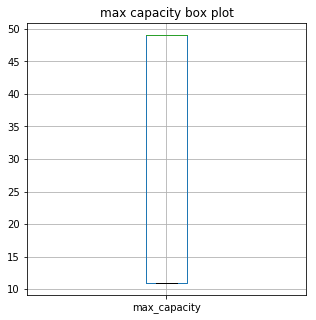

In [820]:
data_prepo.filter(['max_capacity']).boxplot(figsize=(5,5))
plt.title('max capacity box plot')
plt.show()

There is not outliers

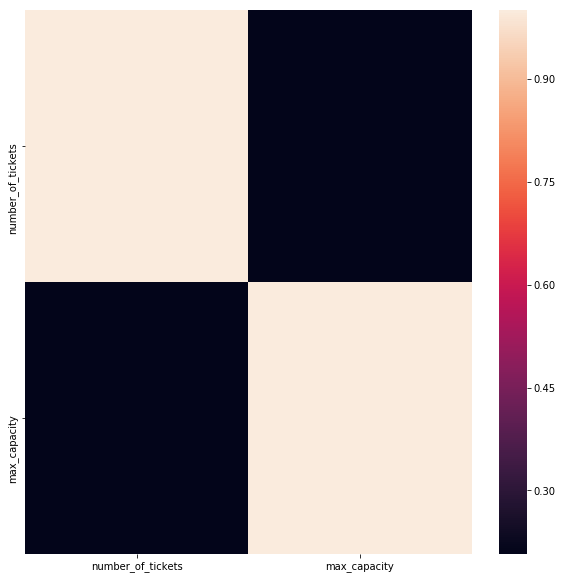

In [832]:
corr = data_prepo.filter(['number_of_tickets','max_capacity']).corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

The variables max_capacity and number_of_tickets are weakly correlated

Good performance means using the attributes xi to generate a prediction that is close to yi, but close has different meanings for different problems. For a regression problem where yi is a real number, performance is measured in terms like the mean squared error (MSE) or the mean absolute error (MAE)

The example starts with some made-up numbers for the targets and the predictions. First, it calculates the errors by simple subtraction; then it shows the calculation of MSE, MAE, and RMSE. Notice that MSE comes out markedly different in magnitude than MAE and RMSE. That’s because MSE is in squared units. For that reason, the RMSE is usually a more usable number to calculate. At the bottom of the listing is a calculation of the variance (mean squared devia- tion from the mean) and the standard deviation (square root of variance) of the targets. These quantities are useful to compare (respectively) to the MSE and RMSE of the prediction errors. For example, if the MSE of the prediction error is roughly the same as the target variance (or the RMSE is roughly the same as target standard deviation), the prediction algorithm is not performing well. You could replace the prediction algorithm with a simple calculation of the mean of the targets and perform as well.

Keumbu,Kendu Bay 

In [379]:
data_prepo.travel_from.value_counts().sort_index()

Awendo        185
Homa Bay      356
Kehancha      172
Kendu Bay       1
Keroka        312
Keumbu         20
Kijauri       556
Kisii        3020
Mbita          21
Migori        386
Ndhiwa         22
Nyachenge     196
Oyugis          2
Rodi           51
Rongo         738
Sirare        191
Sori           20
Name: travel_from, dtype: int64

In [817]:
data1=pd.read_csv('./dataset/test_questions.csv', low_memory=False)
#data1

In [816]:
#data_test_set

Text(0.5, 1.0, '')

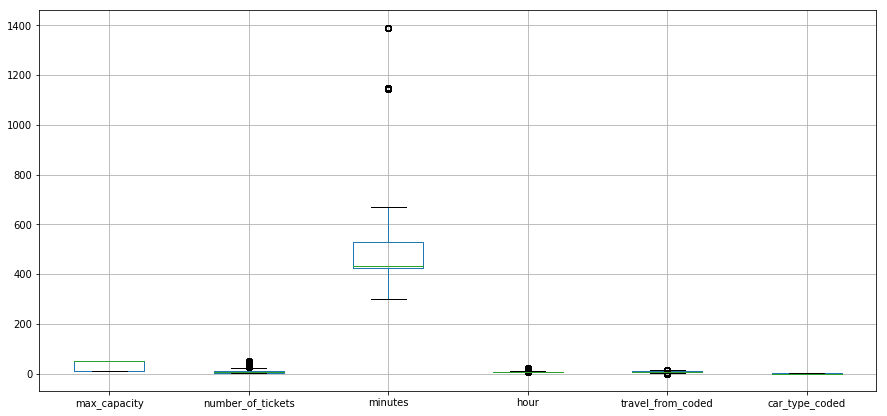

In [836]:
data_prepo.boxplot(figsize=(15,7))
plt.title('')

Awendo
Homa Bay
Kehancha
Kendu Bay
Keroka
Kijauri
Kisii
Mbita
Migori
Ndhiwa
Nyachenge
Rodi
Rongo
Sirare

In [1294]:
from keras.models import Sequential
from keras.layers import Dense
import keras.losses as losses
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import numpy as np

In [1295]:
# define base model
def baseline_model():
# create model
    model = Sequential()
    model.add(Dense(40, input_dim=4, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=losses.MAE, optimizer='adam')
    return model


# define the model
def larger_model():
# create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [1296]:
scaler = StandardScaler() 
def pred_split_NN(X,y):
    seed = 7
    np.random.seed(seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=seed)
    np.random.seed(seed)
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
    pipeline = Pipeline(estimators)
    #scaler.fit(X_train) 
    #X_train=scaler.transform(X_train) 
    #X_test=scaler.transform(X_test)
    model_1 = pipeline
    model_1.fit(X_train,y_train)
    nt_1_test_set = model_1.predict(X_test)
    print (mean_absolute_error(nt_1_test_set,y_test))
    return model_1

def pred_split_SVR(X,y,kernel='rbf', C=1e3, gamma=0.1,degree=2):
    seed = 42
    np.random.seed(seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=seed)
    np.random.seed(seed)
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    print(kernel)
    
    estimators.append(('svm', SVR(kernel, C, gamma,degree)))
    pipeline = Pipeline(estimators)
    #scaler.fit(X_train) 
    #X_train=scaler.transform(X_train) 
    #X_test=scaler.transform(X_test)
    model_1 = pipeline
    model_1.fit(X_train,y_train)
    nt_1_test_set = model_1.predict(X_test)
    print (mean_absolute_error(nt_1_test_set,y_test))
    return model_1

def pred_no_split_SVR(X,y,kernel='rbf', C=1e3, gamma=0.1,degree=2):
    seed = 7
    np.random.seed(seed)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=seed)
    np.random.seed(seed)
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    print(kernel)
    estimators.append(('svm', SVR(kernel, C, gamma,degree)))
    pipeline = Pipeline(estimators)
    #scaler.fit(X_train) 
    #X_train=scaler.transform(X_train) 
    #X_test=scaler.transform(X_test)
    model_1 = pipeline
    model_1.fit(X,y)
    nt_1_test_set = model_1.predict(X)
    print (mean_absolute_error(nt_1_test_set,y))
    return model_1

def pred_split_NN_l(X,y):
    seed = 7
    np.random.seed(seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=seed)
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
    pipeline = Pipeline(estimators)
    #scaler.fit(X_train) 
    #X_train=scaler.transform(X_train) 
    #X_test=scaler.transform(X_test)
    model_1 = pipeline
    model_1.fit(X_train,y_train)
    nt_1_test_set = model_1.predict(X_test)
    print (mean_absolute_error(nt_1_test_set,y_test))
    return model_1

In [1297]:




X_3 = data_prepo.filter(["day","minutes","travel_from_coded",'car_type_coded'], axis=1)
y = data_prepo.number_of_tickets

X_3_test=data_test_set.filter(["day","minutes","travel_from_coded",'car_type_coded'], axis=1)
mod12=pred_split_NN(X_3,y)
df12_=pred_and_save(X_3_test,keys,'12_',mod12)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


5.375826747899644


/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [883]:
X_3 = data_prepo.filter(["day","minutes","travel_from_coded",'car_type_coded'], axis=1)
y = data_prepo.number_of_tickets

X_3_test=data_test_set.filter(["day","minutes","travel_from_coded",'car_type_coded'], axis=1)
mod13=pred_split_NN_l(X_3,y)
df13_=pred_and_save(X_3_test,keys,'13_',mod13)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


5.934397408131803


/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [997]:
X_3 = data_prepo.filter(["day","minutes","travel_from_coded",'car_type_coded'], axis=1)
y = data_prepo.number_of_tickets

X_3_test=data_test_set.filter(["day","minutes","travel_from_coded",'car_type_coded'], axis=1)
mod14=pred_split_SVR(X_3,y, C=1, gamma=99999999999999999999999)
df14=pred_and_save(X_3_test,keys,'14_',mod14)

mod14_=pred_no_split_SVR(X_3,y, C=1, gamma=9999)
df14_=pred_and_save(X_3_test,keys,'14_',mod14_)

#mod15=pred_split_SVR(X_3,y,kernel='poly', C=0.1, gamma=.2,degree=2)
#df15_=pred_and_save(X_3_test,keys,'15_',mod15)

#mod16=pred_split_SVR(X_3,y,kernel='linear', C=0.9, gamma=.2,degree=2)
#df16_=pred_and_save(X_3_test,keys,'16_',mod16)


rbf


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int8, int64, objec

4.51149682092887
rbf


/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


4.006614398260357


/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int8, int64, object were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [839]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
random_state=seed
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [1000]:
model = AdaBoostRegressor(base_estimator=None, n_estimators=50, learning_rate=1.0, loss=’linear’, random_state=None)

SyntaxError: invalid character in identifier (<ipython-input-1000-27816c9fc944>, line 1)

In [921]:
help(kfold.split)

Help on method split in module sklearn.model_selection._split:

split(X, y=None, groups=None) method of sklearn.model_selection._split.KFold instance
    Generate indices to split data into training and test set.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
    
    y : array-like, shape (n_samples,)
        The target variable for supervised learning problems.
    
    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set.
    
    Yields
    ------
    train : ndarray
        The training set indices for that split.
    
    test : ndarray
        The testing set indices for that split.

